# Tumor Classification
## VGG19 is going to be used for tumor classification
### Training

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import tensorflow as tf
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision.models import vgg19, resnet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

In [3]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # VGG excepts 224x224 images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])
dataset = datasets.ImageFolder(root="/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/lung-cancer-detection/", transform=data_transforms)
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [4]:
import torch.nn as nn
from torchvision.models import vgg19

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg19(pretrained=True) # Load pre-trained VGG19 model
for param in model.features.parameters():
    param.requires_grad = False # Freeze the feature extractor layers

model.classifier[6] = nn.Linear(4096, 3) #3 Classes
model = model.to(device) # Move model to device

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
vgg_train_losses = []
vgg_train_accuracies = []
vgg_val_losses = []
vgg_val_accuracies = []

best_val_loss = float('inf')

save_path = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_vgg_model.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        __, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    vgg_train_losses.append(epoch_loss)
    vgg_train_accuracies.append(epoch_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            __, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

        current_val_loss = val_loss / len(val_loader)
        vgg_val_losses.append(val_loss / len(val_loader))
        vgg_val_accuracies.append(val_correct / val_total)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {vgg_val_losses[-1]:.4f}, Val Accuracy: {vgg_val_accuracies[-1]:.4f}")
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        torch.save(model.state_dict(), save_path)
        print("Model saved")

Epoch [1/10], Train Loss: 0.4920, Train Accuracy: 0.7757, Val Loss: 0.2276, Val Accuracy: 0.9389
Model saved
Epoch [2/10], Train Loss: 0.1585, Train Accuracy: 0.9382, Val Loss: 0.1090, Val Accuracy: 0.9583
Model saved
Epoch [3/10], Train Loss: 0.0813, Train Accuracy: 0.9681, Val Loss: 0.1153, Val Accuracy: 0.9611
Epoch [4/10], Train Loss: 0.1056, Train Accuracy: 0.9597, Val Loss: 0.0511, Val Accuracy: 0.9833
Model saved
Epoch [5/10], Train Loss: 0.0402, Train Accuracy: 0.9861, Val Loss: 0.0591, Val Accuracy: 0.9778
Epoch [6/10], Train Loss: 0.0409, Train Accuracy: 0.9868, Val Loss: 0.0330, Val Accuracy: 0.9861
Model saved
Epoch [7/10], Train Loss: 0.0152, Train Accuracy: 0.9965, Val Loss: 0.0448, Val Accuracy: 0.9806
Epoch [8/10], Train Loss: 0.0171, Train Accuracy: 0.9938, Val Loss: 0.0923, Val Accuracy: 0.9694
Epoch [9/10], Train Loss: 0.0386, Train Accuracy: 0.9889, Val Loss: 0.0607, Val Accuracy: 0.9833
Epoch [10/10], Train Loss: 0.0148, Train Accuracy: 0.9938, Val Loss: 0.0427, Va

### Evaluation

VGG19 Evaluation Metrics:
accuracy: 0.9833
precision: 0.9835
recall: 0.9833
f1: 0.9833


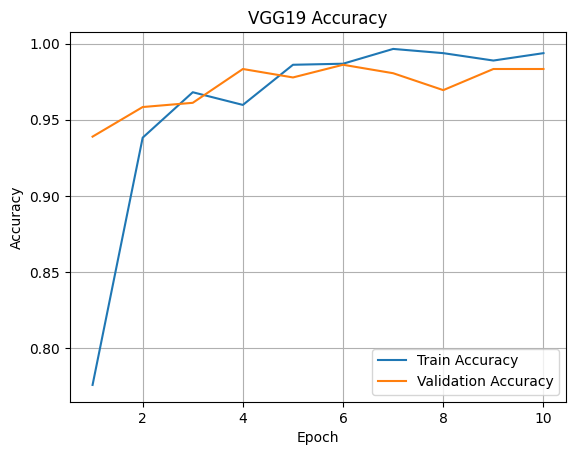

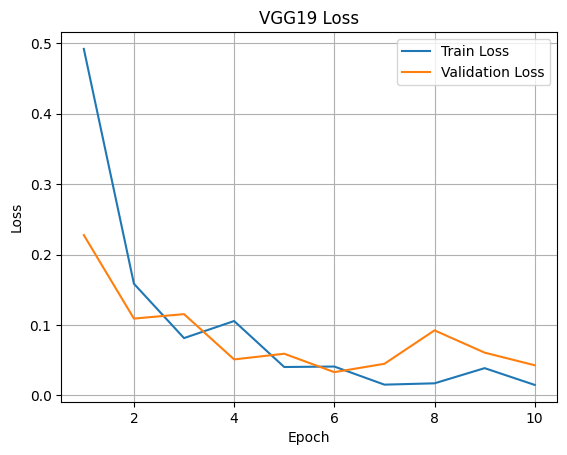

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

sklearn_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

vgg_metrics = {
    "accuracy": round(sklearn_accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1": round(f1, 4)
}
print("VGG19 Evaluation Metrics:")
for key, value in vgg_metrics.items():
    print(f"{key}: {value}")

# ACCURACY
plt.plot(range(1, num_epochs+1), vgg_train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), vgg_val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG19 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# LOSS
plt.plot(range(1, num_epochs+1), vgg_train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), vgg_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG19 Loss")
plt.legend()
plt.grid(True)
plt.show()

## ResNet 50 Training

In [7]:
from torchvision.models import resnet50
# Load pretrained ResNet50 model
base_model = resnet50(pretrained=True)

# Freeze all layers of the base model
for param in base_model.parameters():
    param.requires_grad = False

# Unfreeze the last two residual blocks (layer3 and layer4) and the fully connected layer
for param in base_model.layer3.parameters():
    param.requires_grad = True

for param in base_model.layer4.parameters():
    param.requires_grad = True

num_features = base_model.fc.in_features
base_model.fc = nn.Linear(num_features, 3) # 3 Classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = base_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet50.parameters()), lr=0.0001)

epochs = 10
rn_train_losses = []
rn_train_accuracies = []
rn_val_losses = []
rn_val_accuracies = []

for epoch in range(epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct/total
    rn_train_losses.append(epoch_loss)
    rn_train_accuracies.append(epoch_accuracy)

    resnet50.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

        rn_val_losses.append(val_loss/len(val_loader))
        rn_val_accuracies.append(val_correct/val_total)

        print(f"Epoch {epoch+1}/10, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, Val Loss:{rn_val_losses[-1]:.4f}, Val Acc: {rn_val_accuracies[-1]:.4f}")

Epoch 1/10, Train Loss: 0.0305, Train Acc: 0.9903, Val Loss:0.0142, Val Acc: 0.9972
Epoch 2/10, Train Loss: 0.0248, Train Acc: 0.9889, Val Loss:0.0226, Val Acc: 0.9944
Epoch 3/10, Train Loss: 0.0218, Train Acc: 0.9938, Val Loss:0.1710, Val Acc: 0.9444
Epoch 4/10, Train Loss: 0.0215, Train Acc: 0.9924, Val Loss:0.0351, Val Acc: 0.9889
Epoch 5/10, Train Loss: 0.0232, Train Acc: 0.9917, Val Loss:0.0851, Val Acc: 0.9667
Epoch 6/10, Train Loss: 0.0185, Train Acc: 0.9924, Val Loss:0.0286, Val Acc: 0.9917
Epoch 7/10, Train Loss: 0.0275, Train Acc: 0.9924, Val Loss:0.0451, Val Acc: 0.9889
Epoch 8/10, Train Loss: 0.0071, Train Acc: 0.9972, Val Loss:0.0346, Val Acc: 0.9917
Epoch 9/10, Train Loss: 0.0031, Train Acc: 0.9993, Val Loss:0.0362, Val Acc: 0.9917
Epoch 10/10, Train Loss: 0.0006, Train Acc: 1.0000, Val Loss:0.0352, Val Acc: 0.9917


ResNet50 Evaluation metrics: 
accuracy:0.99
precision:0.9917
recall:0.9917
f1:0.9917


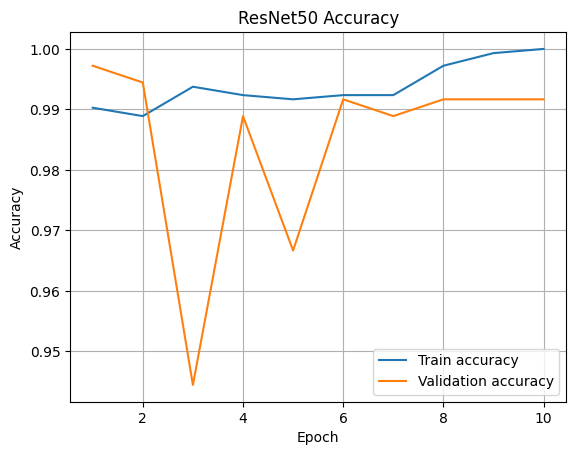

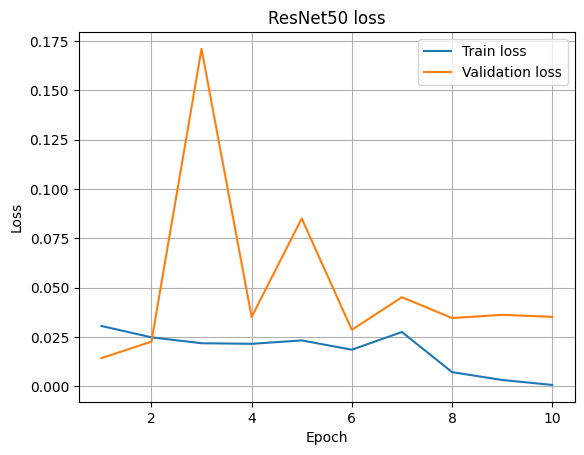

In [10]:
epochs = 10

resnet50.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

resnet_metrics = {
    "accuracy":round(correct / total, 2),
    "precision":round(precision_score(y_true, y_pred, average="weighted"), 4),
    "recall":round(recall_score(y_true, y_pred, average="weighted"),4),
    "f1":round(f1_score(y_true, y_pred, average="weighted"), 4)
}
print("ResNet50 Evaluation metrics: ")
for key, value in resnet_metrics.items():
    if key != "Model":
        print(f"{key}:{value}")

plt.plot(range(1, epochs+1), rn_train_accuracies, label="Train accuracy")
plt.plot(range(1, epochs+1), rn_val_accuracies, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(range(1, epochs+1), rn_train_losses, label="Train loss")
plt.plot(range(1, epochs+1), rn_val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 loss")
plt.legend()
plt.grid(True)
plt.show()

## MobileNet v3

Found 1440 images belonging to 3 classes.
Found 360 images belonging to 3 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 391ms/step - accuracy: 0.3846 - loss: 1.6191 - val_accuracy: 0.4944 - val_loss: 1.0079
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.4811 - loss: 1.0660 - val_accuracy: 0.5389 - val_loss: 0.8953
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 296ms/step - accuracy: 0.5288 - loss: 0.9576 - val_accuracy: 0.5889 - val_loss: 0.8236
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 295ms/step - accuracy: 0.5976 - loss: 0.8559 - val_accuracy: 0.6028 - val_loss: 0.7660
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.6300 - loss: 0.8253 - val_accuracy: 0.6417 - val_loss: 0.7281
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.6456 - loss: 0.7527 - val_accuracy: 0.6611 - val_loss: 0.6940
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.6929 - loss: 0.6862 - val_accuracy: 0.6944 - val_loss: 0.6648
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 298ms/step - accuracy: 0.6831 - loss: 0.6811 - val_accu

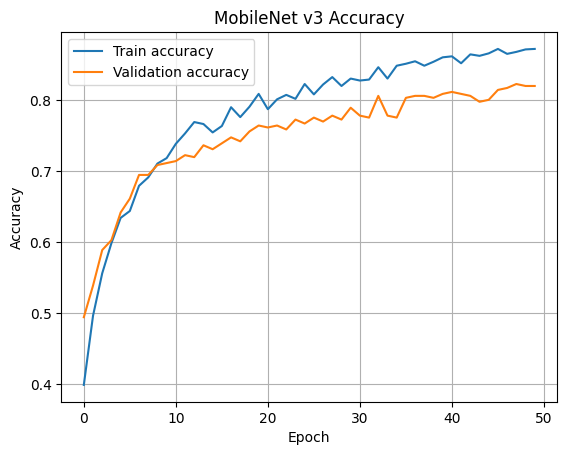

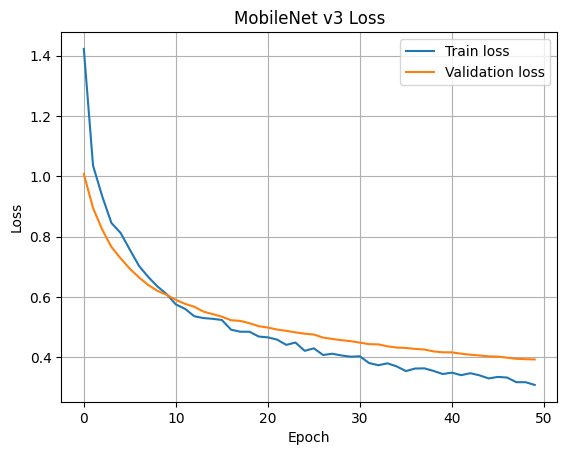

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

data_dir = "/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/lung-cancer-detection/"
img_size = (224, 224)
batch_size = 32
epochs = 50

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_generator, validation_data=val_gen, epochs=epochs)
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes

mobilenet_metrics = {
    "accuracy":round(accuracy_score(y_true, y_pred), 4),
    "precision":round(precision_score(y_true, y_pred, average="weighted"),4),
    "recall":round(recall_score(y_true, y_pred, average="weighted"),4),
    "f1":round(f1_score(y_true, y_pred, average="weighted"),4)
}

print("MobileNet v2 Evaluation metrics: ")
for key, value in mobilenet_metrics.items():
    print(f"{key}:{value}")

plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MobileNet v3 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MobileNet v3 Loss")
plt.legend()
plt.grid(True)
plt.show()

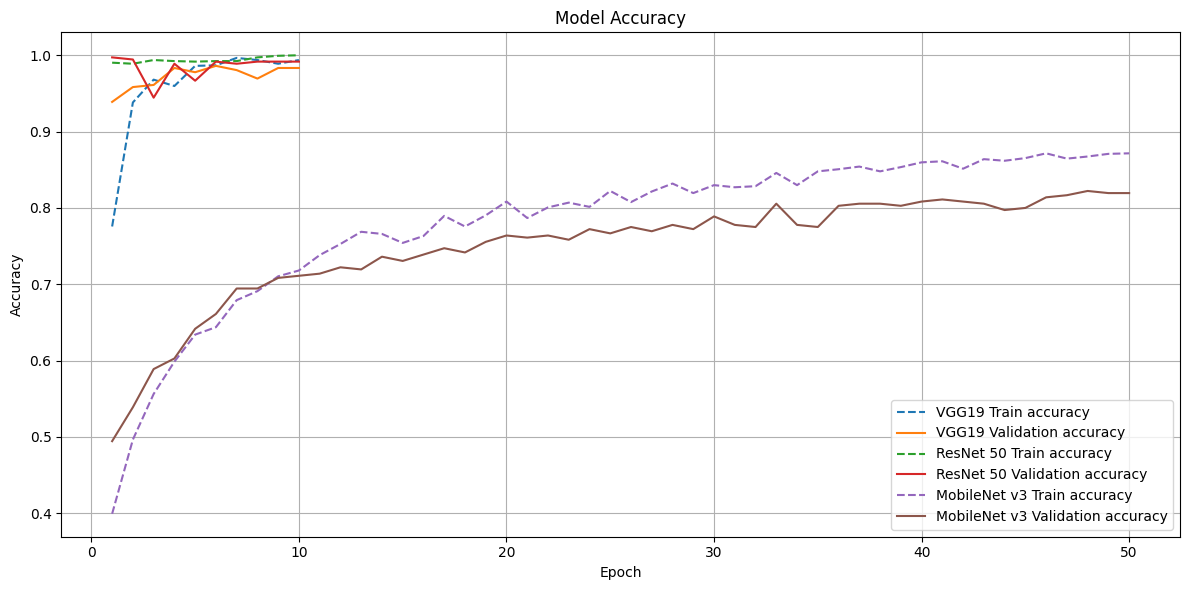

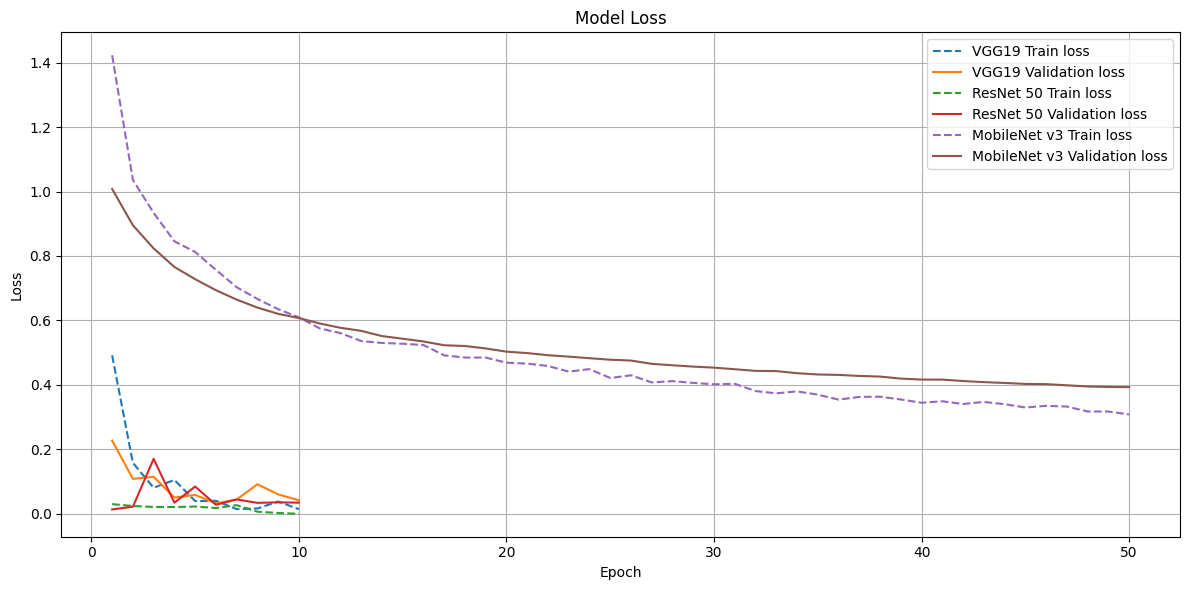

In [12]:
# Epoch ranges for comparison of models
vgg_epochs = range(1,11)
resnet_epochs = range(1,11)
mobilenet_epochs = range(1, len(history.history["accuracy"])+1)

# ACCURACY
plt.figure(figsize=(12,6))
plt.plot(vgg_epochs, vgg_train_accuracies, "--", label="VGG19 Train accuracy")
plt.plot(vgg_epochs, vgg_val_accuracies, label="VGG19 Validation accuracy")
plt.plot(resnet_epochs, rn_train_accuracies, "--", label="ResNet 50 Train accuracy")
plt.plot(resnet_epochs, rn_val_accuracies, label="ResNet 50 Validation accuracy")
plt.plot(mobilenet_epochs, history.history["accuracy"], "--", label="MobileNet v3 Train accuracy")
plt.plot(mobilenet_epochs, history.history["val_accuracy"], label="MobileNet v3 Validation accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LOSS
plt.figure(figsize=(12,6))
plt.plot(vgg_epochs, vgg_train_losses, "--", label="VGG19 Train loss")
plt.plot(vgg_epochs, vgg_val_losses, label="VGG19 Validation loss")
plt.plot(resnet_epochs, rn_train_losses, "--", label="ResNet 50 Train loss")
plt.plot(resnet_epochs, rn_val_losses, label="ResNet 50 Validation loss")
plt.plot(mobilenet_epochs, history.history["loss"], "--", label="MobileNet v3 Train loss")
plt.plot(mobilenet_epochs, history.history["val_loss"], label="MobileNet v3 Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

              accuracy  precision  recall      f1
Model                                            
VGG19           0.9833     0.9835  0.9833  0.9833
ResNet50        0.9900     0.9917  0.9917  0.9917
MobileNet v3    0.8194     0.8234  0.8194  0.8196


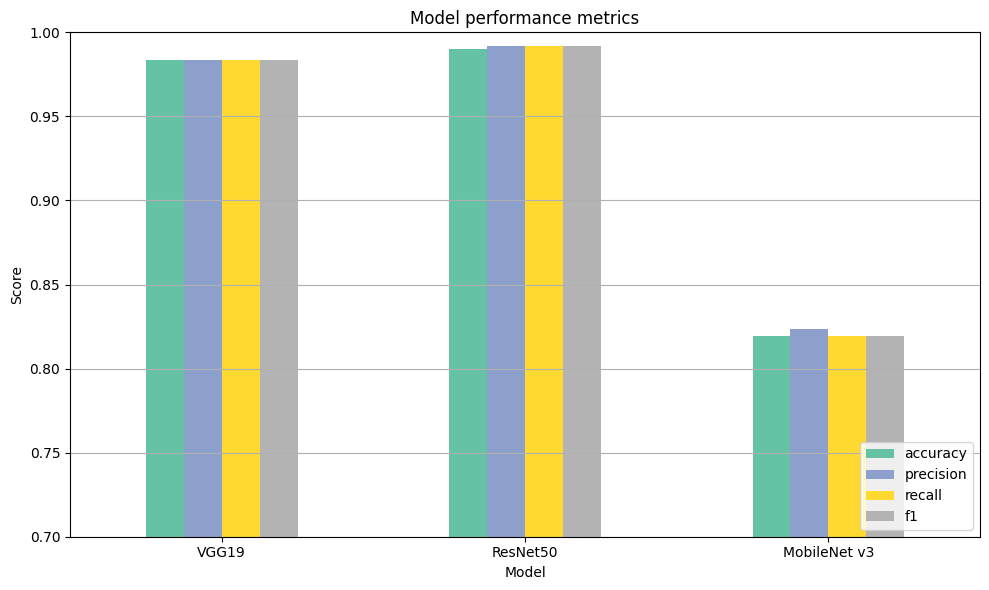

In [13]:
import pandas as pd

all_metrics = [
    {"Model":"VGG19", **vgg_metrics},
    {"Model":"ResNet50", **resnet_metrics},
    {"Model":"MobileNet v3", **mobilenet_metrics}
]

df = pd.DataFrame(all_metrics)
df.set_index("Model", inplace=True)

print(df)

df.plot(kind="bar", figsize=(10,6), colormap="Set2")
plt.title("Model performance metrics")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(True, axis="y")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Breast cancer detection

In [14]:
target_count = 700
img_size=(512,512)

def get_random_transform():
  options = [
      lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),
      lambda img: img.transpose(Image.FLIP_TOP_BOTTOM),
      lambda img: img.rotate(random.uniform(-30,30)),
      lambda img: img.ImageEnhance.Contrast(img).enhance(random.uniform(0.5, 1.5)),
      lambda img: img.ImageEnhance.Sharpness(img).enhance(random.uniform(1.2, 2.0)),
      lambda img: img.ImageEnhance.Color(img).enhance(random.uniform(2.0, 2.5))
  ]
  return random.choice(options)

def augment_and_save(class_name, target_count):
  class_src = os.path.join(base_dir, class_name)
  class_dest = os.path.join(output_dir, class_name)
  os.makedirs(class_dest)

  images = [f for f in os.listdir(class_src)]
  original_count = len(images)

  for img in images:
    shutil.copy(os.path.join(class_src, img), os.path.join(class_dest, img))

  extra_needed = target_count - original_count
  if extra_needed <= 0:
    return

  print(f"Need to generate {extra_needed} more images for {class_name}")

  for i in range(extra_needed):
    img_name = random.choice(images)
    try:
      with Image.open(os.path.join(class_src, img_name)) as img:
        img = img.convert("RGB").resize(img_size)
        transformed_img = get_random_transform()(img)
        save_name = f"aug_{i}_{img_name}"
        transformed_img.save(os.path.join(class_dest, save_name))
    except Exception as e:
      print(f"Error processing {img_name}: {e}")

  for class_name in class_names:
    augment_and_save(class_name, target_count)

  print(f"Augmentation complete for all classes")

In [15]:
data_transforms=transforms.Compose([
    transforms.Resize((224,224)), #VGG excepts 224x224px
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #ImageNet mean and std
])

breast_cancer_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/bc_balanced_data", transform=data_transforms)
train_size = int(0.8 * len(breast_cancer_dataset))
val_size = len(breast_cancer_dataset) - train_size

bc_train, bc_val = torch.utils.data.random_split(breast_cancer_dataset, [train_size, val_size])
bc_train_loader = DataLoader(bc_train, batch_size=32, shuffle=True)
bc_val_loader = DataLoader(bc_val, batch_size=32, shuffle=False)

In [16]:
import torch.optim as optim

VGG19 = vgg19()

for param in VGG19.features.parameters():
  param.requires_grad = False

VGG19.classifier[6] = nn.Linear(4096, 3)
VGG19 = VGG19.to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(VGG19.parameters(), lr=0.001)

num_epochs = 10
vgg_train_losses = []
vgg_train_accuracies = []
vgg_val_losses = []
vgg_val_accuracies = []

for epoch in range(num_epochs):
  VGG19.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in bc_train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = VGG19(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    _,preds = torch.max(outputs, 1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)

  epoch_loss = running_loss / len(bc_train_loader)
  epoch_accuracy = correct / total
  vgg_train_losses.append(epoch_loss)
  vgg_train_accuracies.append(epoch_accuracy)

  # Evaluation
  VGG19.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for inputs, labels in bc_val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      # Permute the dimensions to match the expected format (batch_size, height, width, channels)

      outputs = VGG19(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      _, preds = torch.max(outputs, 1)
      val_correct += (preds == labels).sum().item()
      val_total += labels.size(0)

  vgg_val_losses.append(val_loss / len(bc_val_loader))
  vgg_val_accuracies.append(val_correct / val_total)

  print(f"Epoch {epoch+1}/10, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, Val Loss: {vgg_val_losses[-1]:.4f}, Val Acc: {vgg_val_accuracies[-1]:.4f}")

Epoch 1/10, Train Loss: 1.9244, Train Acc: 0.4022, Val Loss: 1.0355, Val Acc: 0.4514
Epoch 2/10, Train Loss: 1.0242, Train Acc: 0.4468, Val Loss: 0.9423, Val Acc: 0.4884
Epoch 3/10, Train Loss: 1.0099, Train Acc: 0.4745, Val Loss: 0.9104, Val Acc: 0.6157
Epoch 4/10, Train Loss: 0.9766, Train Acc: 0.4774, Val Loss: 0.8867, Val Acc: 0.5625
Epoch 5/10, Train Loss: 0.9290, Train Acc: 0.5093, Val Loss: 0.9040, Val Acc: 0.6481
Epoch 6/10, Train Loss: 0.9847, Train Acc: 0.4688, Val Loss: 0.9516, Val Acc: 0.4514
Epoch 7/10, Train Loss: 0.9820, Train Acc: 0.4855, Val Loss: 0.8712, Val Acc: 0.5856
Epoch 8/10, Train Loss: 0.9575, Train Acc: 0.4844, Val Loss: 0.8412, Val Acc: 0.5347
Epoch 9/10, Train Loss: 0.9541, Train Acc: 0.4902, Val Loss: 0.8795, Val Acc: 0.5069
Epoch 10/10, Train Loss: 0.9503, Train Acc: 0.5075, Val Loss: 0.8858, Val Acc: 0.5324


VGG19 Evaluation Metrics:
accuracy: 0.5324
precision: 0.4275
recall: 0.5324
f1: 0.4387


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


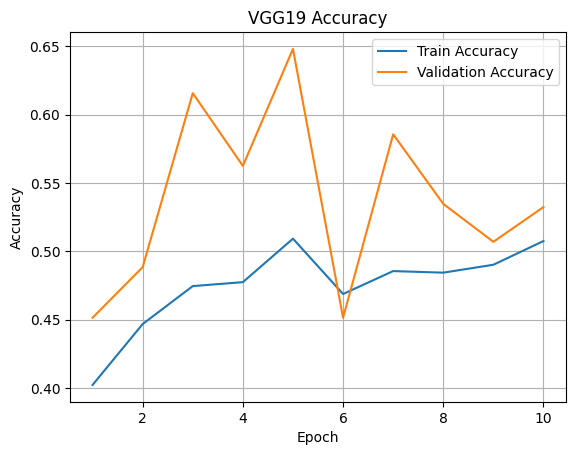

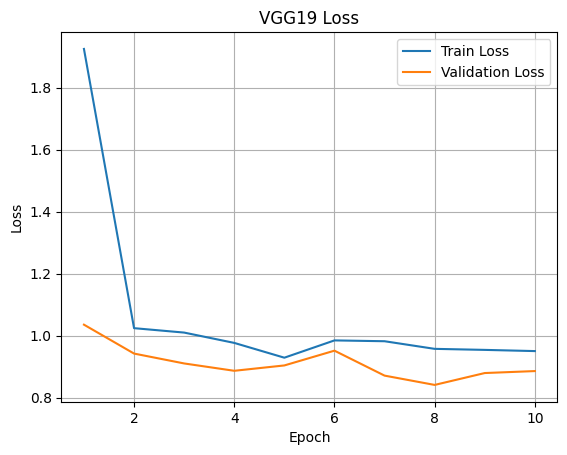

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

VGG19.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in bc_val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = VGG19(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

sklearn_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

vgg_metrics = {
    "accuracy": round(sklearn_accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1": round(f1, 4)
}
print("VGG19 Evaluation Metrics:")
for key, value in vgg_metrics.items():
    print(f"{key}: {value}")

# ACCURACY
plt.plot(range(1, num_epochs+1), vgg_train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), vgg_val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG19 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# LOSS
plt.plot(range(1, num_epochs+1), vgg_train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), vgg_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG19 Loss")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
from torchvision.models import resnet50
resnet50 = resnet50()
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 3) # 3 Classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

epochs = 10
rn_train_losses = []
rn_train_accuracies = []
rn_val_losses = []
rn_val_accuracies = []

for epoch in range(epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in bc_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct/total
    rn_train_losses.append(epoch_loss)
    rn_train_accuracies.append(epoch_accuracy)

    resnet50.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in bc_val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

        rn_val_losses.append(val_loss/len(val_loader))
        rn_val_accuracies.append(val_correct/val_total)

        print(f"Epoch {epoch+1}/10, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, Val Loss:{rn_val_losses[-1]:.4f}, Val Acc: {rn_val_accuracies[-1]:.4f}")

Epoch 1/10, Train Loss: 0.9326, Train Acc: 0.6244, Val Loss:1.6309, Val Acc: 0.4676
Epoch 2/10, Train Loss: 0.7530, Train Acc: 0.7037, Val Loss:1.3174, Val Acc: 0.4421
Epoch 3/10, Train Loss: 0.7368, Train Acc: 0.7083, Val Loss:0.7492, Val Acc: 0.7708
Epoch 4/10, Train Loss: 0.6315, Train Acc: 0.7645, Val Loss:1.3722, Val Acc: 0.4213
Epoch 5/10, Train Loss: 0.5998, Train Acc: 0.7749, Val Loss:0.6124, Val Acc: 0.7917
Epoch 6/10, Train Loss: 0.5742, Train Acc: 0.7899, Val Loss:1.0832, Val Acc: 0.6389
Epoch 7/10, Train Loss: 0.5266, Train Acc: 0.8166, Val Loss:0.8724, Val Acc: 0.5764
Epoch 8/10, Train Loss: 0.5111, Train Acc: 0.8229, Val Loss:0.6340, Val Acc: 0.7940
Epoch 9/10, Train Loss: 0.4363, Train Acc: 0.8507, Val Loss:0.4586, Val Acc: 0.8449
Epoch 10/10, Train Loss: 0.4797, Train Acc: 0.8478, Val Loss:0.6581, Val Acc: 0.8032


ResNet50 Evaluation metrics: 
accuracy:0.8
precision:0.8202
recall:0.8032
f1:0.8033


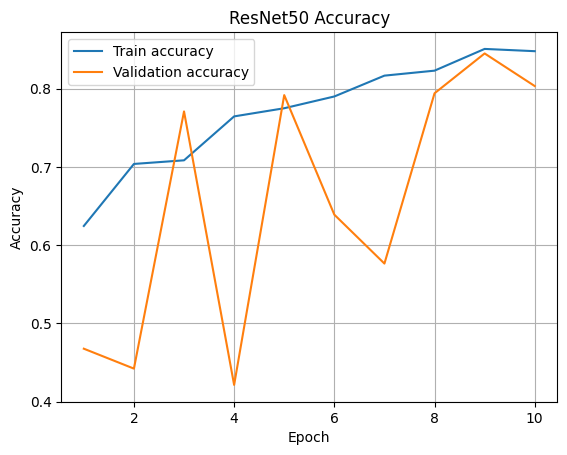

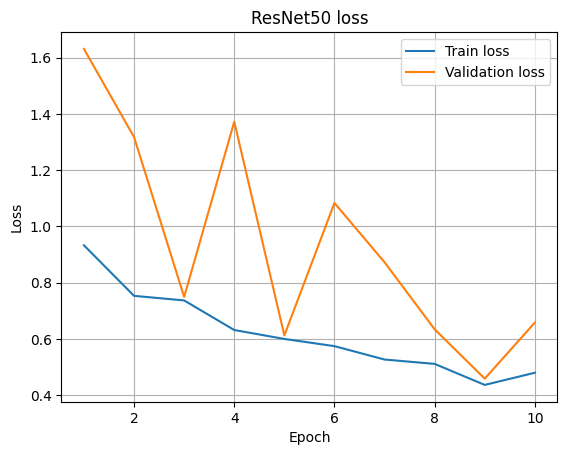

In [21]:
epochs = 10

resnet50.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in bc_val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

resnet_metrics = {
    "accuracy":round(correct / total, 2),
    "precision":round(precision_score(y_true, y_pred, average="weighted"), 4),
    "recall":round(recall_score(y_true, y_pred, average="weighted"),4),
    "f1":round(f1_score(y_true, y_pred, average="weighted"), 4)
}
print("ResNet50 Evaluation metrics: ")
for key, value in resnet_metrics.items():
    if key != "Model":
        print(f"{key}:{value}")

plt.plot(range(1, epochs+1), rn_train_accuracies, label="Train accuracy")
plt.plot(range(1, epochs+1), rn_val_accuracies, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(range(1, epochs+1), rn_train_losses, label="Train loss")
plt.plot(range(1, epochs+1), rn_val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 loss")
plt.legend()
plt.grid(True)
plt.show()

Found 1728 images belonging to 3 classes.
Found 432 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.3603 - loss: 1.2937
Epoch 1: val_accuracy improved from -inf to 0.70833, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - accuracy: 0.3613 - loss: 1.2918 - val_accuracy: 0.7083 - val_loss: 0.8143
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.5998 - loss: 0.9057
Epoch 2: val_accuracy improved from 0.70833 to 0.76620, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 422ms/step - accuracy: 0.6002 - loss: 0.9051 - val_accuracy: 0.7662 - val_loss: 0.6366
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6840 - loss: 0.7529
Epoch 3: val_accuracy improved from 0.76620 to 0.79861, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - accuracy: 0.6842 - loss: 0.7523 - val_accuracy: 0.7986 - val_loss: 0.5436
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7269 - loss: 0.6656
Epoch 4: val_accuracy improved from 0.79861 to 0.82407, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 297ms/step - accuracy: 0.7268 - loss: 0.6655 - val_accuracy: 0.8241 - val_loss: 0.4860
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7564 - loss: 0.5707
Epoch 5: val_accuracy improved from 0.82407 to 0.83102, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 300ms/step - accuracy: 0.7562 - loss: 0.5711 - val_accuracy: 0.8310 - val_loss: 0.4511
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7554 - loss: 0.5763
Epoch 6: val_accuracy improved from 0.83102 to 0.85417, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 304ms/step - accuracy: 0.7555 - loss: 0.5760 - val_accuracy: 0.8542 - val_loss: 0.4189
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7539 - loss: 0.5510
Epoch 7: val_accuracy improved from 0.85417 to 0.85648, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 297ms/step - accuracy: 0.7542 - loss: 0.5505 - val_accuracy: 0.8565 - val_loss: 0.3998
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7981 - loss: 0.4928
Epoch 8: val_accuracy improved from 0.85648 to 0.86343, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 297ms/step - accuracy: 0.7980 - loss: 0.4929 - val_accuracy: 0.8634 - val_loss: 0.3805
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7983 - loss: 0.4933
Epoch 9: val_accuracy improved from 0.86343 to 0.86806, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.7985 - loss: 0.4930 - val_accuracy: 0.8681 - val_loss: 0.3663
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8235 - loss: 0.4215
Epoch 10: val_accuracy improved from 0.86806 to 0.87731, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 300ms/step - accuracy: 0.8234 - loss: 0.4217 - val_accuracy: 0.8773 - val_loss: 0.3590
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8339 - loss: 0.4019
Epoch 11: val_accuracy did not improve from 0.87731
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 325ms/step - accuracy: 0.8340 - loss: 0.4020 - val_accuracy: 0.8750 - val_loss: 0.3459
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8428 - loss: 0.4083
Epoch 12: val_accuracy did not improve from 0.87731
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - accuracy: 0.8426 - loss: 0.4084 - val_accuracy: 0.8750 - val_loss: 0.3382
Epoch 13/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8305 - loss: 0.4032
Epoch 13: val_accuracy improved from 0.87731 to 0.87963, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 298ms/step - accuracy: 0.8305 - loss: 0.4033 - val_accuracy: 0.8796 - val_loss: 0.3317
Epoch 14/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8134 - loss: 0.4325
Epoch 14: val_accuracy did not improve from 0.87963
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 279ms/step - accuracy: 0.8137 - loss: 0.4318 - val_accuracy: 0.8773 - val_loss: 0.3251
Epoch 15/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8472 - loss: 0.3820
Epoch 15: val_accuracy did not improve from 0.87963
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 0.8471 - loss: 0.3820 - val_accuracy: 0.8773 - val_loss: 0.3199
Epoch 16/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8382 - loss: 0.3706
Epoch 16: val_accuracy did not improve from 0.87963
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 266ms/step - accuracy: 0.8381 - loss: 0.3706 - val_accuracy: 0.8796 - val_loss: 0.3148
Epoch 17/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8738 - loss: 0.3530
Epoch 17: val_accuracy d

54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step - accuracy: 0.8286 - loss: 0.3711 - val_accuracy: 0.8819 - val_loss: 0.3074
Epoch 19/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8577 - loss: 0.3496
Epoch 19: val_accuracy did not improve from 0.88194
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.8579 - loss: 0.3493 - val_accuracy: 0.8819 - val_loss: 0.3018
Epoch 20/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8849 - loss: 0.3029
Epoch 20: val_accuracy improved from 0.88194 to 0.88889, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step - accuracy: 0.8847 - loss: 0.3033 - val_accuracy: 0.8889 - val_loss: 0.2990
Epoch 21/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8693 - loss: 0.3306
Epoch 21: val_accuracy did not improve from 0.88889
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.8693 - loss: 0.3305 - val_accuracy: 0.8889 - val_loss: 0.2948
Epoch 22/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8642 - loss: 0.3357
Epoch 22: val_accuracy did not improve from 0.88889
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 0.8643 - loss: 0.3354 - val_accuracy: 0.8889 - val_loss: 0.2943
Epoch 23/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8756 - loss: 0.3050
Epoch 23: val_accuracy did not improve from 0.88889
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 310ms/step - accuracy: 0.8755 - loss: 0.3053 - val_accuracy: 0.8866 - val_loss: 0.2887
Epoch 24/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.8713 - loss: 0.3162
Epoch 24: val_accuracy d

54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.8903 - loss: 0.2835 - val_accuracy: 0.8912 - val_loss: 0.2792
Epoch 27/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8762 - loss: 0.3060
Epoch 27: val_accuracy did not improve from 0.89120
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.8763 - loss: 0.3057 - val_accuracy: 0.8912 - val_loss: 0.2782
Epoch 28/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8835 - loss: 0.2832
Epoch 28: val_accuracy did not improve from 0.89120
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.8835 - loss: 0.2834 - val_accuracy: 0.8912 - val_loss: 0.2785
Epoch 29/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8861 - loss: 0.2795
Epoch 29: val_accuracy did not improve from 0.89120
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - accuracy: 0.8863 - loss: 0.2795 - val_accuracy: 0.8866 - val_loss: 0.2773
Epoch 30/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8873 - loss: 0.2702
Epoch 30: val_accuracy d

54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 334ms/step - accuracy: 0.9052 - loss: 0.2531 - val_accuracy: 0.8958 - val_loss: 0.2668
Epoch 36/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8930 - loss: 0.2574
Epoch 36: val_accuracy did not improve from 0.89583
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 267ms/step - accuracy: 0.8931 - loss: 0.2573 - val_accuracy: 0.8889 - val_loss: 0.2687
Epoch 37/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9021 - loss: 0.2426
Epoch 37: val_accuracy improved from 0.89583 to 0.89815, saving model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.9020 - loss: 0.2430 - val_accuracy: 0.8981 - val_loss: 0.2649
Epoch 38/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8916 - loss: 0.2637
Epoch 38: val_accuracy did not improve from 0.89815
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 325ms/step - accuracy: 0.8918 - loss: 0.2633 - val_accuracy: 0.8958 - val_loss: 0.2663
Epoch 39/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8940 - loss: 0.2582
Epoch 39: val_accuracy did not improve from 0.89815
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 306ms/step - accuracy: 0.8941 - loss: 0.2581 - val_accuracy: 0.8935 - val_loss: 0.2646
Epoch 40/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9207 - loss: 0.2230
Epoch 40: val_accuracy did not improve from 0.89815
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step - accuracy: 0.9205 - loss: 0.2234 - val_accuracy: 0.8958 - val_loss: 0.2635
Epoch 41/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8984 - loss: 0.2562
Epoch 41: val_accuracy d

54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.9210 - loss: 0.2095 - val_accuracy: 0.9005 - val_loss: 0.2583
Epoch 45/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9061 - loss: 0.2352
Epoch 45: val_accuracy did not improve from 0.90046
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 266ms/step - accuracy: 0.9061 - loss: 0.2351 - val_accuracy: 0.8981 - val_loss: 0.2583
Epoch 46/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9196 - loss: 0.2194
Epoch 46: val_accuracy did not improve from 0.90046
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 263ms/step - accuracy: 0.9196 - loss: 0.2194 - val_accuracy: 0.9005 - val_loss: 0.2567
Epoch 47/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9168 - loss: 0.2269
Epoch 47: val_accuracy did not improve from 0.90046
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 263ms/step - accuracy: 0.9167 - loss: 0.2268 - val_accuracy: 0.9005 - val_loss: 0.2571
Epoch 48/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9243 - loss: 0.2135
Epoch 48: val_accuracy d

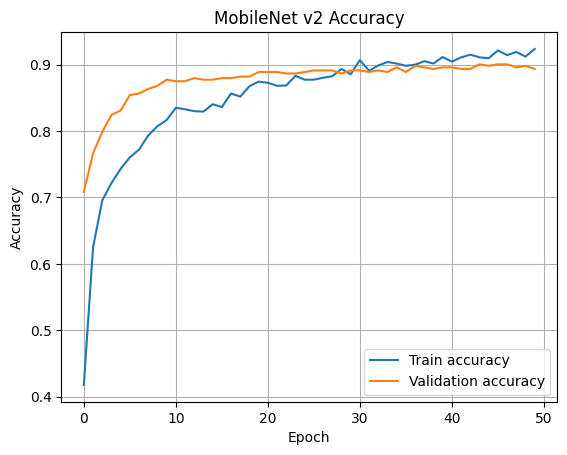

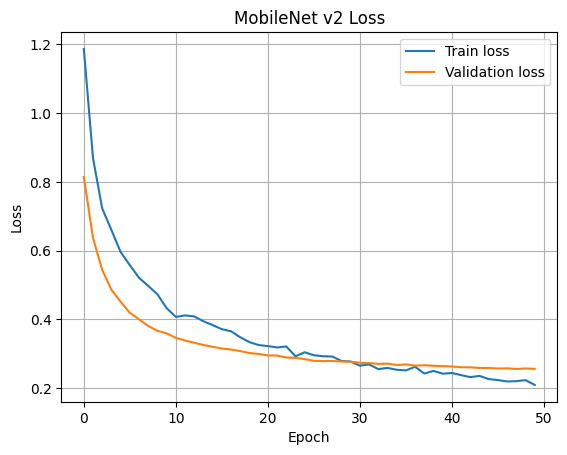

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define paths and parameters
data_dir = "/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/bc_balanced_data"
img_size = (224, 224)
batch_size = 32
epochs = 50

# Data augmentation and splitting
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Build the MobileNetV2 model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# Define the ModelCheckpoint callback
# This will save the best model weights based on validation accuracy
model_save_path = "/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_mobilenetv2_model.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=model_save_path,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# Train the model with the callback
history = model.fit(
    train_generator,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[checkpoint_callback]  # Add the callback to the training process
)

# --- Model Evaluation (after training) ---

# Make predictions on the validation set
# We need to reload the best model weights to evaluate the best performing model,
# as the training history might not reflect the best model if it overfits later epochs.
best_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
best_model.trainable = False
x = best_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation="softmax")(x)
best_model = Model(inputs=best_model.input, outputs=output)
best_model.load_weights(model_save_path) # Load the best weights
best_model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


# Reset the validation generator to ensure predictions are made from the beginning
val_gen.reset()
y_pred_probs = best_model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes

# Calculate evaluation metrics
mobilenet_metrics = {
    "accuracy": round(accuracy_score(y_true, y_pred), 4),
    "precision": round(precision_score(y_true, y_pred, average="weighted", zero_division=0), 4),
    "recall": round(recall_score(y_true, y_pred, average="weighted", zero_division=0), 4),
    "f1": round(f1_score(y_true, y_pred, average="weighted", zero_division=0), 4)
}

print("MobileNet v2 Evaluation metrics (from the best saved model): ")
for key, value in mobilenet_metrics.items():
    print(f"{key}:{value}")

# --- Plotting Training History ---

plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MobileNet v2 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MobileNet v2 Loss")
plt.legend()
plt.grid(True)
plt.show()

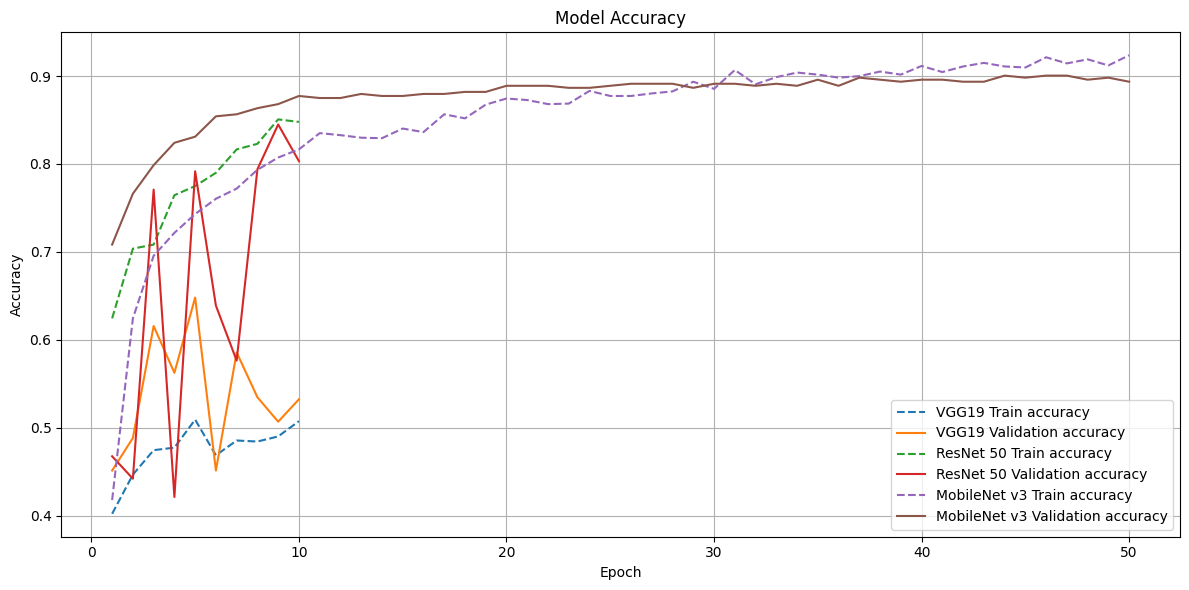

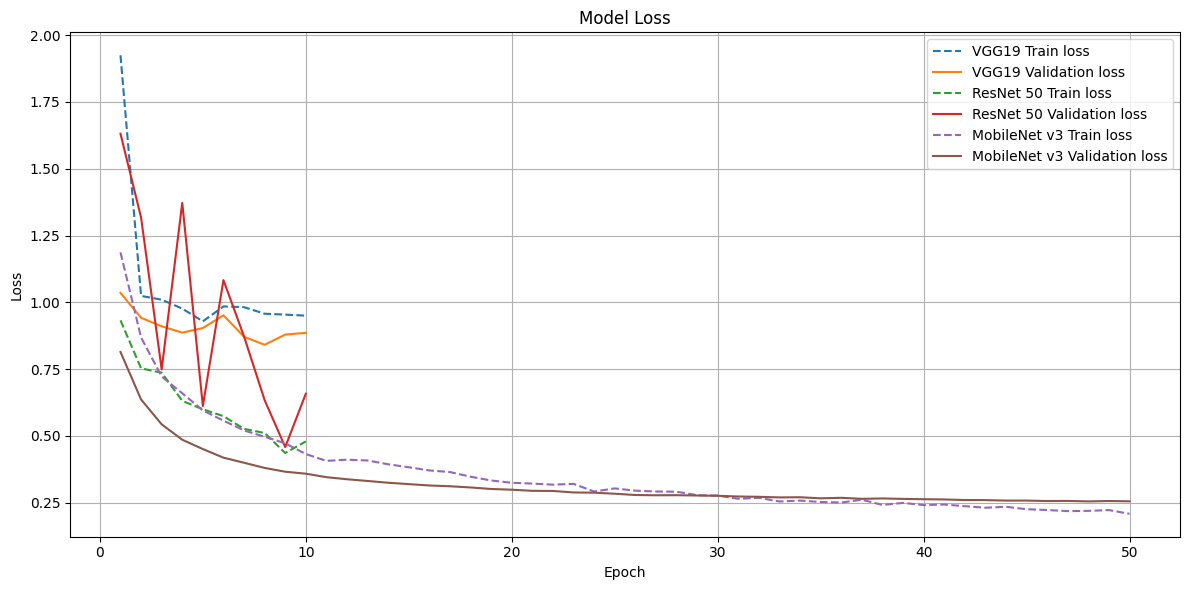

In [23]:
# Epoch ranges for comparison of models
vgg_epochs = range(1,11)
resnet_epochs = range(1,11)
mobilenet_epochs = range(1, len(history.history["accuracy"])+1)

# ACCURACY
plt.figure(figsize=(12,6))
plt.plot(vgg_epochs, vgg_train_accuracies, "--", label="VGG19 Train accuracy")
plt.plot(vgg_epochs, vgg_val_accuracies, label="VGG19 Validation accuracy")
plt.plot(resnet_epochs, rn_train_accuracies, "--", label="ResNet 50 Train accuracy")
plt.plot(resnet_epochs, rn_val_accuracies, label="ResNet 50 Validation accuracy")
plt.plot(mobilenet_epochs, history.history["accuracy"], "--", label="MobileNet v3 Train accuracy")
plt.plot(mobilenet_epochs, history.history["val_accuracy"], label="MobileNet v3 Validation accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LOSS
plt.figure(figsize=(12,6))
plt.plot(vgg_epochs, vgg_train_losses, "--", label="VGG19 Train loss")
plt.plot(vgg_epochs, vgg_val_losses, label="VGG19 Validation loss")
plt.plot(resnet_epochs, rn_train_losses, "--", label="ResNet 50 Train loss")
plt.plot(resnet_epochs, rn_val_losses, label="ResNet 50 Validation loss")
plt.plot(mobilenet_epochs, history.history["loss"], "--", label="MobileNet v3 Train loss")
plt.plot(mobilenet_epochs, history.history["val_loss"], label="MobileNet v3 Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

              accuracy  precision  recall      f1
Model                                            
VGG19           0.5324     0.4275  0.5324  0.4387
ResNet50        0.8000     0.8202  0.8032  0.8033
MobileNet v3    0.9005     0.9007  0.9005  0.9001


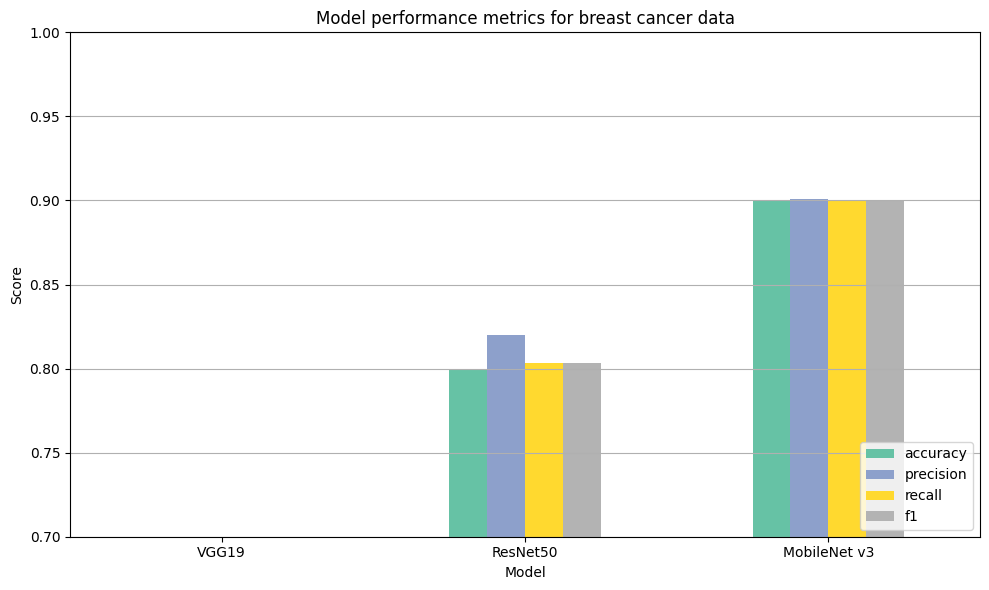

In [24]:
import pandas as pd

all_metrics = [
    {"Model":"VGG19", **vgg_metrics},
    {"Model":"ResNet50", **resnet_metrics},
    {"Model":"MobileNet v3", **mobilenet_metrics}
]

df = pd.DataFrame(all_metrics)
df.set_index("Model", inplace=True)

print(df)

df.plot(kind="bar", figsize=(10,6), colormap="Set2")
plt.title("Model performance metrics for breast cancer data")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(True, axis="y")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Brain Tumor

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
import cv2
from tqdm import tqdm
import itertools

# Renamed to avoid conflict with torchvision.models.resnet50
def load_data_helper(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [9]:
TRAIN_DIR_NO = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TRAIN/NO/'
TRAIN_DIR_YES = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TRAIN/YES/'
TEST_DIR_NO = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TEST/NO/'
TEST_DIR_YES = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TEST/YES/'
VAL_DIR_NO = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/VAL/NO/'
VAL_DIR_YES = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/VAL/YES/'
IMG_SIZE = (224,224)

# Function to load images from a directory and assign a specific label
def load_images_with_label(dir_path, label, img_size=(224, 224)):
    X = []
    y = []
    if os.path.exists(dir_path):
        print(f"Loading images from: {dir_path}")
        for file in tqdm(os.listdir(dir_path)):
            if not file.startswith('.'):
                img_path = os.path.join(dir_path, file)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        # Ensure the image has 3 channels (for color images)
                        if len(img.shape) == 2: # Convert grayscale to color
                            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                        elif img.shape[2] == 4: # Convert RGBA to RGB
                            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
                        X.append(img)
                        y.append(label)
                    else:
                        print(f"Warning: Could not read image: {img_path}")
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    else:
        print(f"Directory not found: {dir_path}")
    return np.array(X), np.array(y)


# Load data for each class and split with explicit labels
X_train_no, y_train_no = load_images_with_label(TRAIN_DIR_NO, 0, IMG_SIZE) # 0 for NO
X_train_yes, y_train_yes = load_images_with_label(TRAIN_DIR_YES, 1, IMG_SIZE) # 1 for YES
X_test_no, y_test_no = load_images_with_label(TEST_DIR_NO, 0, IMG_SIZE)
X_test_yes, y_test_yes = load_images_with_label(TEST_DIR_YES, 1, IMG_SIZE)
X_val_no, y_val_no = load_images_with_label(VAL_DIR_NO, 0, IMG_SIZE)
X_val_yes, y_val_yes = load_images_with_label(VAL_DIR_YES, 1, IMG_SIZE)


# Concatenate data from both classes for each split
X_train = np.concatenate((X_train_no, X_train_yes), axis=0)
y_train = np.concatenate((y_train_no, y_train_yes), axis=0)
X_test = np.concatenate((X_test_no, X_test_yes), axis=0)
y_test = np.concatenate((y_test_no, y_test_yes), axis=0)
X_val = np.concatenate((X_val_no, X_val_yes), axis=0)
y_val = np.concatenate((y_val_no, y_val_yes), axis=0)

# Update labels dictionary (assuming 'NO' is class 0 and 'YES' is class 1)
labels = {0: 'NO', 1: 'YES'}

print("Data loading complete.")
print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")
print(f"Val data shape: {X_val.shape}, Val labels shape: {y_val.shape}")

Loading images from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TRAIN/NO/


100%|██████████| 1436/1436 [00:21<00:00, 68.37it/s] 


Loading images from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TRAIN/YES/


100%|██████████| 1445/1445 [00:17<00:00, 82.89it/s] 


Loading images from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TEST/NO/


100%|██████████| 290/290 [00:01<00:00, 149.93it/s]


Loading images from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/TEST/YES/


100%|██████████| 281/281 [00:02<00:00, 137.63it/s]


Loading images from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/VAL/NO/


100%|██████████| 284/284 [00:01<00:00, 142.36it/s]


Loading images from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/preprocessed_data/brain_tumor_split/VAL/YES/


100%|██████████| 287/287 [00:02<00:00, 131.83it/s]


Data loading complete.
Train data shape: (2881, 224, 224, 3), Train labels shape: (2881,)
Test data shape: (571, 224, 224, 3), Test labels shape: (571,)
Val data shape: (571, 224, 224, 3), Val labels shape: (571,)


In [10]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [11]:
# Define the same data transforms used for the previous data
data_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.Resize((224, 224)), # VGG excepts 224x224 images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# Create custom Dataset classes or use TensorDataset for the numpy arrays
# Since we have features (X) and labels (y) separately as numpy arrays, TensorDataset is suitable

# Convert numpy arrays to torch tensors and apply transformations
X_train_tensor = torch.stack([data_transforms(img) for img in X_train])
y_train_tensor = torch.from_numpy(y_train).long() # Labels should be long type for CrossEntropyLoss

X_val_tensor = torch.stack([data_transforms(img) for img in X_val])
y_val_tensor = torch.from_numpy(y_val).long()

X_test_tensor = torch.stack([data_transforms(img) for img in X_test])
y_test_tensor = torch.from_numpy(y_test).long()

# Create TensorDatasets
train_dataset_bt = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_bt = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_bt = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)


# Create DataLoaders
batch_size = 32
train_loader_bt = DataLoader(train_dataset_bt, batch_size=batch_size, shuffle=True)
val_loader_bt = DataLoader(val_dataset_bt, batch_size=batch_size, shuffle=False)
test_loader_bt = DataLoader(test_dataset_bt, batch_size=batch_size, shuffle=False)

print("Brain Tumor Data Preprocessing Complete.")
print(f"Number of training samples: {len(train_dataset_bt)}")
print(f"Number of validation samples: {len(val_dataset_bt)}")
print(f"Number of test samples: {len(test_dataset_bt)}")

Brain Tumor Data Preprocessing Complete.
Number of training samples: 2881
Number of validation samples: 571
Number of test samples: 571


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg19 = vgg19() # Load pre-trained VGG19 model
for param in model_vgg19.features.parameters():
    param.requires_grad = False # Freeze the feature extractor layers

model_vgg19.classifier[6] = nn.Linear(4096, 2) #2 Classes: Yes or No
model_vgg19 = model_vgg19.to(device) # Move model to device

In [13]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.Adam(model_vgg19.parameters(), lr=0.0001)

num_epochs = 10
vgg_train_losses = []
vgg_train_accuracies = []
vgg_val_losses = []
vgg_val_accuracies = []

for epoch in range(num_epochs):
    model_vgg19.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader_bt:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_vgg19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        __, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader_bt)
    epoch_accuracy = correct / total
    vgg_train_losses.append(epoch_loss)
    vgg_train_accuracies.append(epoch_accuracy)

    model_vgg19.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_bt:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model_vgg19(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            __, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
        vgg_val_losses.append(val_loss / len(val_loader_bt))
        vgg_val_accuracies.append(val_correct / val_total)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {vgg_val_losses[-1]:.4f}, Val Accuracy: {vgg_val_accuracies[-1]:.4f}")

Epoch [1/10], Train Loss: 0.6168, Train Accuracy: 0.6623, Val Loss: 0.5382, Val Accuracy: 0.7233
Epoch [2/10], Train Loss: 0.5342, Train Accuracy: 0.7272, Val Loss: 0.7172, Val Accuracy: 0.5919
Epoch [3/10], Train Loss: 0.4956, Train Accuracy: 0.7570, Val Loss: 0.6418, Val Accuracy: 0.6743
Epoch [4/10], Train Loss: 0.4721, Train Accuracy: 0.7699, Val Loss: 0.3860, Val Accuracy: 0.8214
Epoch [5/10], Train Loss: 0.4240, Train Accuracy: 0.7980, Val Loss: 0.3975, Val Accuracy: 0.8284
Epoch [6/10], Train Loss: 0.3748, Train Accuracy: 0.8278, Val Loss: 0.3056, Val Accuracy: 0.8687
Epoch [7/10], Train Loss: 0.3500, Train Accuracy: 0.8344, Val Loss: 0.2599, Val Accuracy: 0.8967
Epoch [8/10], Train Loss: 0.3081, Train Accuracy: 0.8681, Val Loss: 0.3103, Val Accuracy: 0.8546
Epoch [9/10], Train Loss: 0.3521, Train Accuracy: 0.8330, Val Loss: 0.2628, Val Accuracy: 0.8827
Epoch [10/10], Train Loss: 0.2950, Train Accuracy: 0.8684, Val Loss: 0.2420, Val Accuracy: 0.8914


VGG19 Evaluation Metrics for Brain Tumor Data:
accuracy: 0.8914
precision: 0.9018
recall: 0.8914
f1: 0.8907


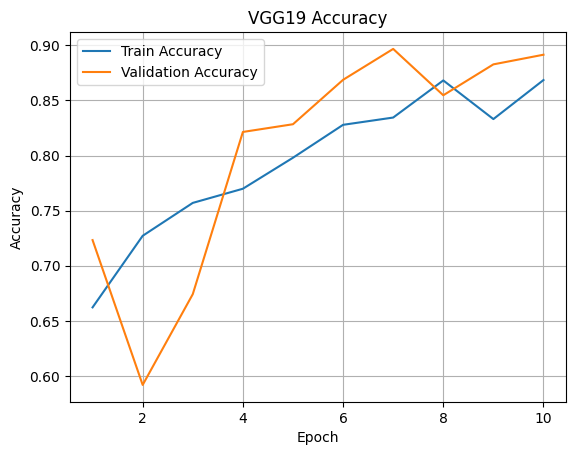

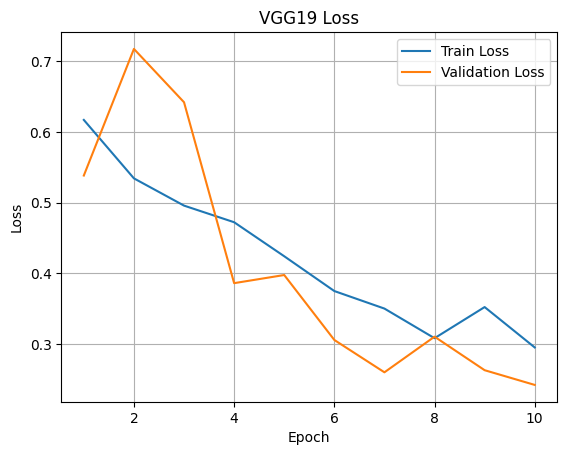

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model_vgg19.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader_bt:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg19(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

sklearn_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

vgg_metrics = {
    "accuracy": round(sklearn_accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1": round(f1, 4)
}
print("VGG19 Evaluation Metrics for Brain Tumor Data:")
for key, value in vgg_metrics.items():
    print(f"{key}: {value}")

# ACCURACY
plt.plot(range(1, num_epochs+1), vgg_train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), vgg_val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG19 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# LOSS
plt.plot(range(1, num_epochs+1), vgg_train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), vgg_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG19 Loss")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from torchvision.models import resnet50
resnet50 = resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 2) # 2 Classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

epochs = 10
rn_train_losses = []
rn_train_accuracies = []
rn_val_losses = []
rn_val_accuracies = []

# --- Additions for saving the best model ---
# Define the directory and filename for the saved model
save_dir = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models'
os.makedirs(save_dir, exist_ok=True) # Create the directory if it doesn't exist
model_save_path = os.path.join(save_dir, 'best_resnet50_model.pth')

# Initialize the best validation loss to a very large number
best_val_loss = float('inf')
# --- End of additions ---

for epoch in range(epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader_bt:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader_bt)
    epoch_accuracy = correct/total
    rn_train_losses.append(epoch_loss)
    rn_train_accuracies.append(epoch_accuracy)

    resnet50.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_bt:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

        current_val_loss = val_loss / len(val_loader_bt)
        rn_val_losses.append(current_val_loss)
        rn_val_accuracies.append(val_correct/val_total)

        print(f"Epoch {epoch+1}/10, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, Val Loss:{rn_val_losses[-1]:.4f}, Val Acc: {rn_val_accuracies[-1]:.4f}")

    # --- Logic to save the best model ---
    if current_val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {current_val_loss:.4f}. Saving model...")
        best_val_loss = current_val_loss
        # Save the model's state dictionary
        torch.save(resnet50.state_dict(), model_save_path)
    # --- End of logic ---

Epoch 1/10, Train Loss: 0.4920, Train Acc: 0.8306, Val Loss:0.4423, Val Acc: 0.8529
Validation loss improved from inf to 0.4423. Saving model...
Epoch 2/10, Train Loss: 0.4177, Train Acc: 0.8584, Val Loss:0.3901, Val Acc: 0.8739
Validation loss improved from 0.4423 to 0.3901. Saving model...
Epoch 3/10, Train Loss: 0.3778, Train Acc: 0.8737, Val Loss:0.3691, Val Acc: 0.8704
Validation loss improved from 0.3901 to 0.3691. Saving model...
Epoch 4/10, Train Loss: 0.3605, Train Acc: 0.8740, Val Loss:0.3294, Val Acc: 0.8967
Validation loss improved from 0.3691 to 0.3294. Saving model...
Epoch 5/10, Train Loss: 0.3392, Train Acc: 0.8771, Val Loss:0.3210, Val Acc: 0.8932
Validation loss improved from 0.3294 to 0.3210. Saving model...
Epoch 6/10, Train Loss: 0.3228, Train Acc: 0.8865, Val Loss:0.3023, Val Acc: 0.9072
Validation loss improved from 0.3210 to 0.3023. Saving model...
Epoch 7/10, Train Loss: 0.3117, Train Acc: 0.8945, Val Loss:0.3013, Val Acc: 0.8949
Validation loss improved from 0

ResNet50 Evaluation metrics for Brain Tumor Data: 
accuracy:0.91
precision:0.9129
recall:0.9124
f1:0.9124


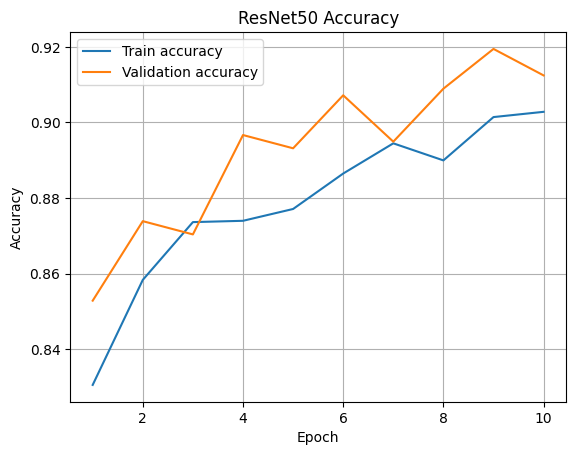

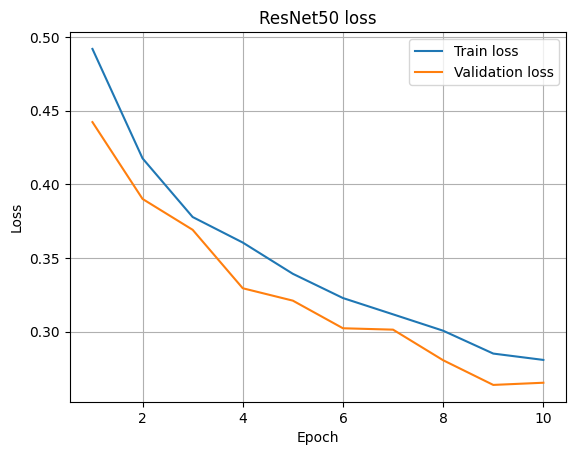

In [18]:
epochs = 10

resnet50.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader_bt:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

resnet_metrics = {
    "accuracy":round(correct / total, 2),
    "precision":round(precision_score(y_true, y_pred, average="weighted"), 4),
    "recall":round(recall_score(y_true, y_pred, average="weighted"),4),
    "f1":round(f1_score(y_true, y_pred, average="weighted"), 4)
}
print("ResNet50 Evaluation metrics for Brain Tumor Data: ")
for key, value in resnet_metrics.items():
    if key != "Model":
        print(f"{key}:{value}")

plt.plot(range(1, epochs+1), rn_train_accuracies, label="Train accuracy")
plt.plot(range(1, epochs+1), rn_val_accuracies, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(range(1, epochs+1), rn_train_losses, label="Train loss")
plt.plot(range(1, epochs+1), rn_val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 loss")
plt.legend()
plt.grid(True)
plt.show()

Converting PyTorch DataLoaders to NumPy arrays...


100%|██████████| 18/18 [00:00<00:00, 227.49it/s]


Conversion complete.
Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 31s 211ms/step - accuracy: 0.5162 - loss: 0.8514 - val_accuracy: 0.7040 - val_loss: 0.5891
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.6410 - loss: 0.6726 - val_accuracy: 0.7951 - val_loss: 0.4792
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7191 - loss: 0.5383 - val_accuracy: 0.8301 - val_loss: 0.4114
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7679 - loss: 0.4854 - val_accuracy: 0.8529 - val_loss: 0.3661
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7662 - loss: 0.4700 - val_accuracy: 0.8687 - val_loss: 0.3368
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8275 - loss: 0.3924 - val_accuracy: 0.8757 - val_loss: 0.3138
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8351 - loss: 0.3787 - val_accuracy: 0.8897 - val_loss: 0.2948
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8500 - loss: 0.3438 - 

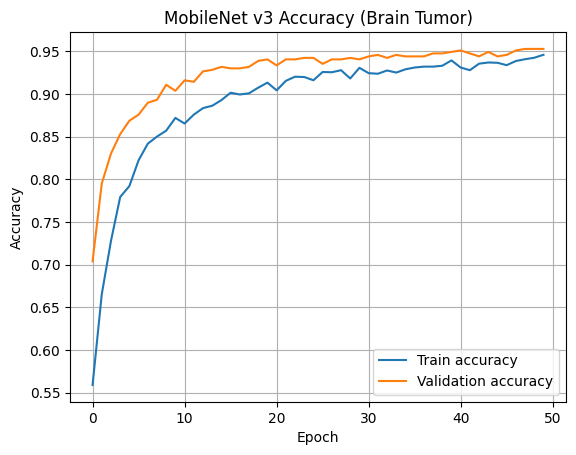

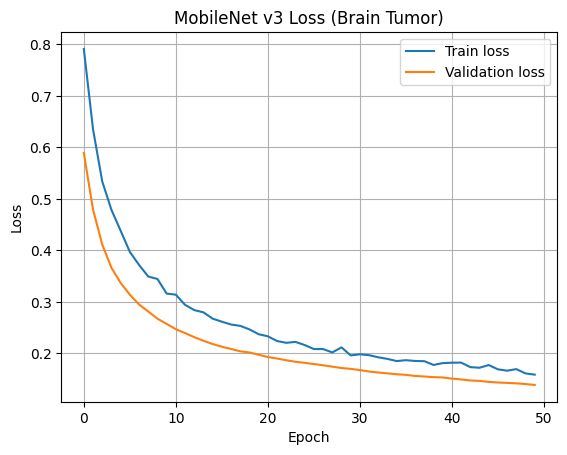

In [19]:
img_size = (224, 224)
batch_size = 32
epochs = 50

# We already have train_loader_bt and val_loader_bt which are PyTorch DataLoaders
# MobileNetV2 from Keras expects data in a different format (NumPy arrays or TensorFlow Datasets)
# We will need to iterate through the PyTorch DataLoaders to get the data as NumPy arrays
# or create TensorFlow Datasets from the numpy arrays X_train, y_train, X_val, y_val

# Option 1: Convert PyTorch DataLoaders to NumPy arrays (can consume a lot of memory for large datasets)
# Function to convert PyTorch DataLoader to numpy arrays
def dataloader_to_numpy(dataloader):
    all_inputs = []
    all_labels = []
    for inputs, labels in tqdm(dataloader):
        all_inputs.append(inputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_inputs), np.concatenate(all_labels)

print("Converting PyTorch DataLoaders to NumPy arrays...")
X_train_np, y_train_np = dataloader_to_numpy(train_loader_bt)
X_val_np, y_val_np = dataloader_to_numpy(val_loader_bt)
print("Conversion complete.")

# Ensure labels are one-hot encoded for categorical_crossentropy
y_train_encoded = tf.keras.utils.to_categorical(y_train_np, num_classes=2) # 2 classes: YES/NO
y_val_encoded = tf.keras.utils.to_categorical(y_val_np, num_classes=2)

# Option 2 (more memory efficient for very large datasets, not used here as Option 1 is sufficient):
# Create TensorFlow Datasets
# train_dataset_tf = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_encoded)).batch(batch_size)
# val_dataset_tf = tf.data.Dataset.from_tensor_slices((X_val_np, y_val_encoded)).batch(batch_size)


base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(2, activation="softmax")(x) # 2 classes for brain tumor (YES/NO)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model using the NumPy arrays
# Using validation_split or validation_data with fit is possible with NumPy arrays
history = model.fit(X_train_np, y_train_encoded, validation_data=(X_val_np, y_val_encoded), epochs=epochs)

# Evaluate the model
y_pred_probs = model.predict(X_val_np)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_val_np # Use the original numeric labels for metrics

mobilenet_metrics_bt = {
    "accuracy":round(accuracy_score(y_true, y_pred), 4),
    "precision":round(precision_score(y_true, y_pred, average="weighted"),4),
    "recall":round(recall_score(y_true, y_pred, average="weighted"),4),
    "f1":round(f1_score(y_true, y_pred, average="weighted"),4)
}

print("MobileNet v2 Evaluation metrics for Brain Tumor Data: ")
for key, value in mobilenet_metrics_bt.items():
    print(f"{key}:{value}")

# Plot training history
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MobileNet v3 Accuracy (Brain Tumor)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MobileNet v3 Loss (Brain Tumor)")
plt.legend()
plt.grid(True)
plt.show()

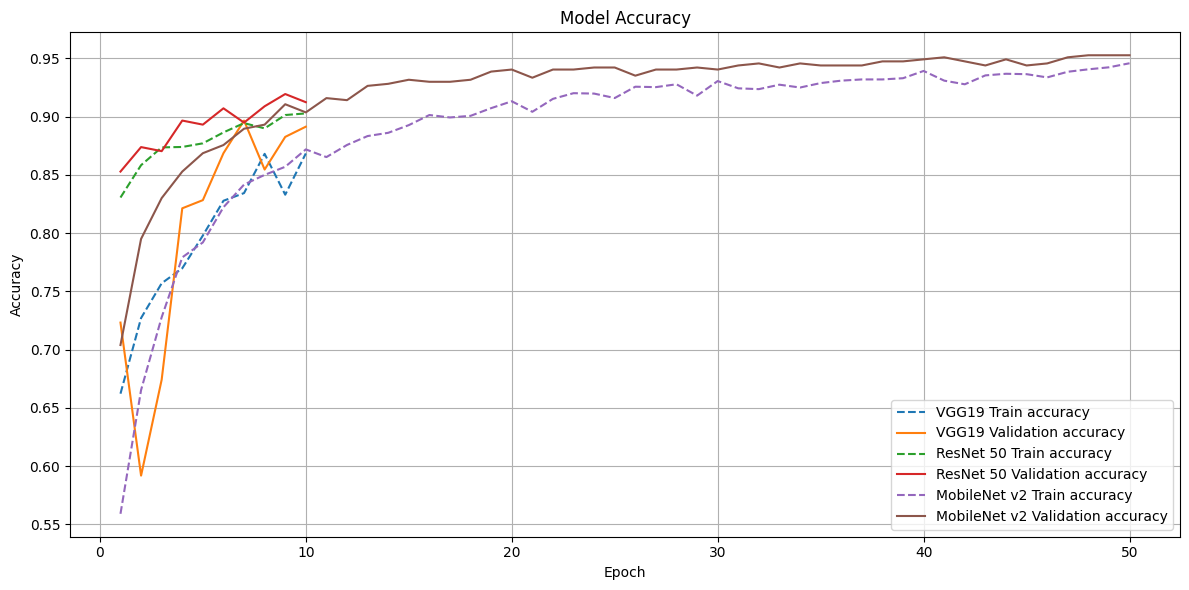

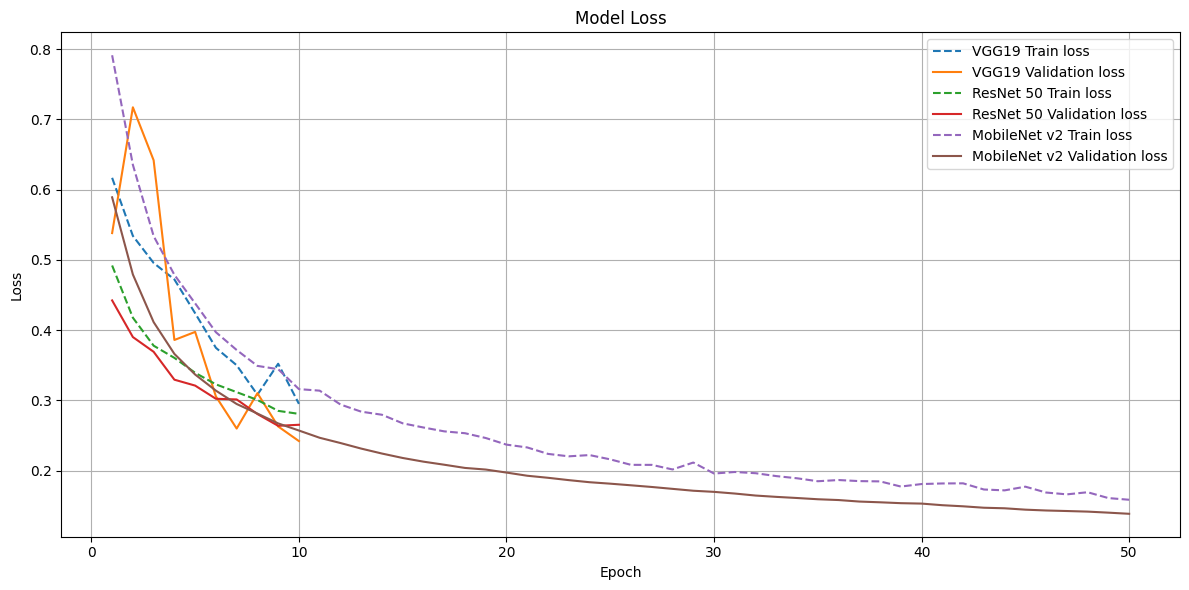

In [20]:
# Epoch ranges for comparison of models
vgg_epochs = range(1,11)
resnet_epochs = range(1,11)
mobilenet_epochs = range(1, len(history.history["accuracy"])+1)

# ACCURACY
plt.figure(figsize=(12,6))
plt.plot(vgg_epochs, vgg_train_accuracies, "--", label="VGG19 Train accuracy")
plt.plot(vgg_epochs, vgg_val_accuracies, label="VGG19 Validation accuracy")
plt.plot(resnet_epochs, rn_train_accuracies, "--", label="ResNet 50 Train accuracy")
plt.plot(resnet_epochs, rn_val_accuracies, label="ResNet 50 Validation accuracy")
plt.plot(mobilenet_epochs, history.history["accuracy"], "--", label="MobileNet v2 Train accuracy")
plt.plot(mobilenet_epochs, history.history["val_accuracy"], label="MobileNet v2 Validation accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LOSS
plt.figure(figsize=(12,6))
plt.plot(vgg_epochs, vgg_train_losses, "--", label="VGG19 Train loss")
plt.plot(vgg_epochs, vgg_val_losses, label="VGG19 Validation loss")
plt.plot(resnet_epochs, rn_train_losses, "--", label="ResNet 50 Train loss")
plt.plot(resnet_epochs, rn_val_losses, label="ResNet 50 Validation loss")
plt.plot(mobilenet_epochs, history.history["loss"], "--", label="MobileNet v2 Train loss")
plt.plot(mobilenet_epochs, history.history["val_loss"], label="MobileNet v2 Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

              accuracy  precision  recall      f1
Model                                            
VGG19           0.8914     0.9018  0.8914  0.8907
ResNet50        0.9100     0.9129  0.9124  0.9124
MobileNet v3    0.9527     0.9530  0.9527  0.9527


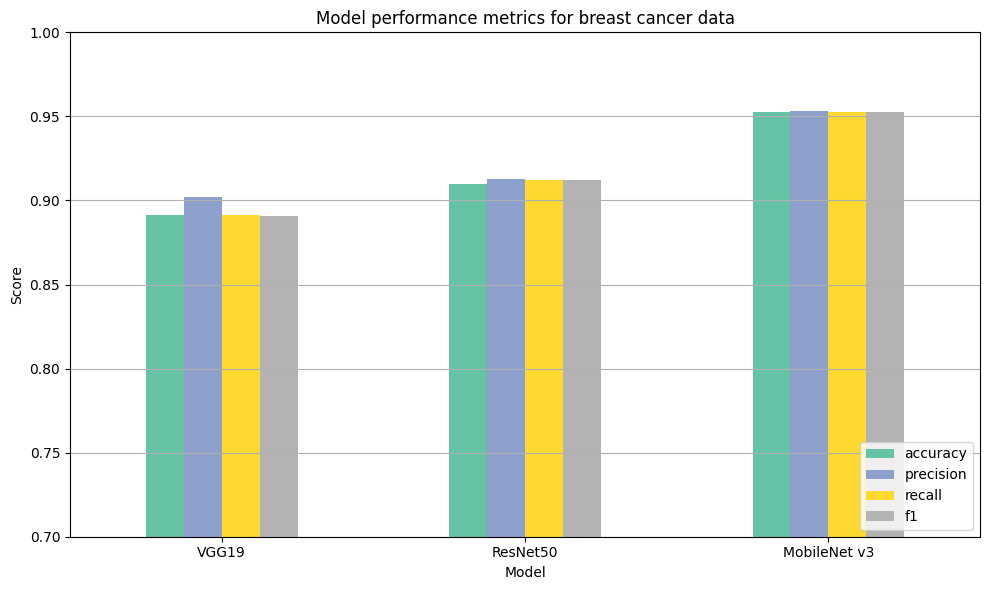

In [21]:
import pandas as pd

all_metrics = [
    {"Model":"VGG19", **vgg_metrics},
    {"Model":"ResNet50", **resnet_metrics},
    {"Model":"MobileNet v3", **mobilenet_metrics_bt}
]

df = pd.DataFrame(all_metrics)
df.set_index("Model", inplace=True)

print(df)

df.plot(kind="bar", figsize=(10,6), colormap="Set2")
plt.title("Model performance metrics for breast cancer data")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(True, axis="y")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

For lung cancer the VGG19 model had the best performance, for the breast cancer data the MobileNet v2 model had the best performance and for the brain tumor data the resnet50 had the best performance. We now want to create a model that takes all this data into account and classify them correctly. This model could be an ensemble model of all 3 models we used VGG19, ResNet50 and MobileNet v2.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, models, transforms
import os
import copy

# --- Configuration ---
BREASTCANCER_DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/breast_cancer/'
LUNGCANCER_DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/lung_cancer/'
NUM_CLASSES = 3
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_resnet50_model_3_classes_combined.pth'

# --- Data Transformations ---
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Load and Combine Datasets ---
# Load individual datasets
breast_cancer_datasets = {x: datasets.ImageFolder(os.path.join(BREASTCANCER_DATA_DIR, x), data_transforms[x]) for x in ['train', 'val']}
lung_cancer_datasets = {x: datasets.ImageFolder(os.path.join(LUNGCANCER_DATA_DIR, x), data_transforms[x]) for x in ['train', 'val']}

# Combine datasets
# Note: This assumes that the class-to-index mapping is consistent across datasets.
# For example, if 'class_A' is index 0 in the breast cancer dataset, any 'class_A'
# in the lung cancer dataset should also ideally be index 0. ImageFolder assigns
# indices based on alphabetical order of folder names.
image_datasets = {
    'train': ConcatDataset([breast_cancer_datasets['train'], lung_cancer_datasets['train']]),
    'val': ConcatDataset([breast_cancer_datasets['val'], lung_cancer_datasets['val']])
}

# --- Create DataLoaders ---
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# It's good practice to ensure class names are what you expect.
# We'll take the class names from one of the original datasets,
# assuming the class structure is identical.
class_names = breast_cancer_datasets['train'].classes
print(f"Using data from: {BREASTCANCER_DATA_DIR} and {LUNGCANCER_DATA_DIR}")
print(f"Detected classes: {class_names}")
print(f"Training set size: {dataset_sizes['train']} images")
print(f"Validation set size: {dataset_sizes['val']} images")


# --- Initialize Model ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights='IMAGENET1K_V1')  # Use pretrained weights
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, NUM_CLASSES)
model = model.to(device)

# --- Define Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Saved best model to {MODEL_SAVE_PATH} with accuracy: {best_acc:.4f}")


print("Training complete.")
print(f'Best val Acc: {best_acc:4f}')

# load best model weights
model.load_state_dict(best_model_wts)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Using data from: /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/breast_cancer/ and /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/lung_cancer/
Detected classes: ['benign', 'malignant', 'normal']
Training set size: 3168 images
Validation set size: 396 images
Epoch 1/10
----------
train Loss: 0.9326 Acc: 0.5316
val Loss: 2.8744 Acc: 0.4242
Saved best model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_resnet50_model_3_classes_combined.pth with accuracy: 0.4242
Epoch 2/10
----------
train Loss: 0.7370 Acc: 0.6266
val Loss: 1.4203 Acc: 0.5707
Saved best model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_resnet50_model_3_classes_combined.pth with accuracy: 0.5707
Epoch 3/10
----------
train Loss: 0.7281 Acc: 0.6392
val Loss: 0.6518 Acc: 0.6818
Saved best model to /content/drive/MyDrive/Colab Notebooks/Tumor Classification Pr

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, models, transforms
import os
import copy

# --- Configuration ---
BREASTCANCER_DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/breast_cancer/'
LUNGCANCER_DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/datasets/split_data/lung_cancer/'
NUM_CLASSES = 3
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
# Changed the model save path to reflect the new architecture
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/Tumor Classification Project/saved_models/best_vgg19_model_3_classes_combined.pth'

# --- Data Transformations ---
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Load and Combine Datasets ---
# Load individual datasets
breast_cancer_datasets = {x: datasets.ImageFolder(os.path.join(BREASTCANCER_DATA_DIR, x), data_transforms[x]) for x in ['train', 'val']}
lung_cancer_datasets = {x: datasets.ImageFolder(os.path.join(LUNGCANCER_DATA_DIR, x), data_transforms[x]) for x in ['train', 'val']}

# Combine datasets
# Note: This assumes that the class-to-index mapping is consistent across datasets.
# For example, if 'class_A' is index 0 in the breast cancer dataset, any 'class_A'
# in the lung cancer dataset should also ideally be index 0. ImageFolder assigns
# indices based on alphabetical order of folder names.
image_datasets = {
    'train': ConcatDataset([breast_cancer_datasets['train'], lung_cancer_datasets['train']]),
    'val': ConcatDataset([breast_cancer_datasets['val'], lung_cancer_datasets['val']])
}

# --- Create DataLoaders ---
# Adjusted num_workers to 2 for common compatibility, can be set higher if resources allow
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# It's good practice to ensure class names are what you expect.
# We'll take the class names from one of the original datasets,
# assuming the class structure is identical.
class_names = breast_cancer_datasets['train'].classes
print(f"Using data from: {BREASTCANCER_DATA_DIR} and {LUNGCANCER_DATA_DIR}")
print(f"Detected classes: {class_names}")
print(f"Training set size: {dataset_sizes['train']} images")
print(f"Validation set size: {dataset_sizes['val']} images")


# --- Initialize Model ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# [MODIFIED] Load the pretrained VGG19 model
model = models.vgg19(weights='IMAGENET1K_V1')

# [MODIFIED] The classifier in VGG is a Sequential module. We replace the last layer.
# VGG19's classifier has 6 layers (0-5) and a final output layer at index 6.
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, NUM_CLASSES)

model = model.to(device)

# --- Define Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
# Ensure optimizer is created after model parameters are finalized
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Saved best model to {MODEL_SAVE_PATH} with accuracy: {best_acc:.4f}")


print("Training complete.")
print(f'Best val Acc: {best_acc:4f}')

# load best model weights
model.load_state_dict(best_model_wts)